<a href="https://colab.research.google.com/github/LIZKA30/ML_2025_autumn/blob/main/%D0%BB%D0%B0%D0%B1%D0%B05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import LinearOperator, cg
from scipy.optimize._linesearch import scalar_search_wolfe2
from datetime import datetime
from collections import defaultdict


class LineSearchTool(object):
    def __init__(self, method='Wolfe', **kwargs):
        self._method = method
        if method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError(f'Unknown method {method}')

    def line_search(self, oracle, x_k, d_k, previous_alpha=None):
        if self._method == 'Constant':
            return self.c

        alpha_0 = self.alpha_0 if previous_alpha is None else previous_alpha
        phi_0 = oracle.func(x_k)
        grad_0 = oracle.grad(x_k)
        phi_0_deriv = np.dot(grad_0, d_k)

        if self._method == 'Wolfe':
            res = scalar_search_wolfe2(
                phi=lambda a: oracle.func(x_k + a * d_k),
                derphi=lambda a: np.dot(oracle.grad(x_k + a * d_k), d_k),
                c1=self.c1, c2=self.c2
            )
            alpha = res[0]
            if alpha is None:
                alpha = self.alpha_0
                while oracle.func(x_k + alpha * d_k) > phi_0 + self.c1 * alpha * phi_0_deriv:
                    alpha *= 0.5
            return alpha

        elif self._method == 'Armijo':
            alpha = alpha_0
            beta = 0.5
            while oracle.func(x_k + alpha * d_k) > phi_0 + self.c1 * alpha * phi_0_deriv:
                alpha *= beta
            return alpha


def get_line_search_tool(line_search_options=None):
    if isinstance(line_search_options, LineSearchTool):
        return line_search_options
    elif isinstance(line_search_options, dict):
        return LineSearchTool(**line_search_options)
    else:
        return LineSearchTool()



from datetime import datetime
from collections import defaultdict
import numpy as np

def gradient_descent(oracle, x_0, tolerance=1e-5, max_iter=10000,
                            line_search_options=None, trace=False, display=False):

    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = x_0.copy()
    start_time = datetime.now()

    for k in range(max_iter):
        grad = oracle.grad(x_k)
        grad_norm = np.linalg.norm(grad)


        if grad_norm <= tolerance:
            if trace:
                history['iterations'] = k
            return x_k, 'success', history

        d_k = -grad


        alpha_k = line_search_tool.line_search(oracle, x_k, d_k)
        if alpha_k is None or alpha_k < 1e-16:
            if trace:
                history['iterations'] = k
            return x_k, 'line_search_fail', history


        x_k = x_k + alpha_k * d_k


        if trace:
            history['time'].append((datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(grad_norm)

        if display and k % 10 == 0:
            print(f"Iter {k:4d}: f={oracle.func(x_k):.6f}, ||grad||={grad_norm:.3e}, α={alpha_k:.3e}")


    if trace:
        history['iterations'] = max_iter
    return x_k, 'iterations_exceeded', history



def newton(oracle, x_0, tolerance=1e-5, max_iter=100,
                  line_search_options=None, trace=False, display=False, cg_tol=1e-5):
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = x_0.copy()
    start_time = datetime.now()

    for k in range(max_iter):
        grad = oracle.grad(x_k)
        grad_norm = np.linalg.norm(grad)
        if grad_norm ** 2 <= tolerance ** 2:
            return x_k, 'success', history

        n = len(x_k)
        H_linop = LinearOperator((n, n), matvec=lambda v: oracle.hess_vec(x_k, v))
        d_k, info = cg(H_linop, -grad, rtol=cg_tol, maxiter=n)
        if info != 0:
            print(f"⚠️ CG не сошёлся (info={info})")

        alpha_k = line_search_tool.line_search(oracle, x_k, d_k)
        if alpha_k is None:
            return x_k, 'line_search_fail', history

        x_k = x_k + alpha_k * d_k

        if trace:
            history['time'].append((datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(grad_norm)
        if display and k % 5 == 0:
            print(f"Iter {k:3d}: f={oracle.func(x_k):.6e}, ||grad||={grad_norm:.3e}, α={alpha_k:.3e}")

    return x_k, 'iterations_exceeded', history

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.special import expit
from scipy.sparse.linalg import LinearOperator


class BaseSmoothOracle(object):

    def func(self, x):
        raise NotImplementedError('Func oracle not implemented.')

    def grad(self, x):
        raise NotImplementedError('Grad oracle not implemented.')

    def hess(self, x):
        raise NotImplementedError('Hessian oracle not implemented.')

    def func_directional(self, x, d, alpha):
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        return np.squeeze(self.grad(x + alpha * d).dot(d))


class QuadraticOracle(BaseSmoothOracle):
    def __init__(self, A, b):
        import scipy.sparse as sp
        if sp.issparse(A):
            self.A = A.tocsr()
            if not np.allclose(self.A.toarray(), self.A.toarray().T):
                raise ValueError("A must be symmetric")
        else:
            self.A = np.array(A)
            if not np.allclose(self.A, self.A.T):
                raise ValueError("A must be symmetric")
        self.b = b

    def func(self, x):
        Ax = self.A.dot(x)
        return 0.5 * x.dot(Ax) - self.b.dot(x)

    def grad(self, x):
        return self.A.dot(x) - self.b

    def hess(self, x):
        return self.A



from scipy.special import expit

class SparseLogRegOracle(BaseSmoothOracle):
    def __init__(self, A, b, regcoef):

        self.A = A.tocsr()
        self.b = b
        self.regcoef = regcoef
        self.m = A.shape[0]

    def func(self, x):
        z = self.A.dot(x)
        return np.mean(np.logaddexp(0, -self.b * z)) + 0.5 * self.regcoef * np.dot(x, x)

    def grad(self, x):
        z = self.A.dot(x)
        sigma = expit(-self.b * z)
        weighted = self.b * sigma
        g = -(self.A.T.dot(weighted)) / self.m + self.regcoef * x
        return np.array(g).ravel()

    def hess_vec(self, x, v):

        z = self.A.dot(x)
        s = expit(self.b * z)
        D = s * (1 - s)
        Av = self.A.dot(v)
        ADv = D * Av
        return (self.A.T.dot(ADv)) / self.m + self.regcoef * v


def create_log_reg_oracle(A, b, regcoef, oracle_type='usual'):

    if sp.issparse(A):
        A = A.tocsr()
        matvec_Ax = lambda x: A.dot(x)
        matvec_ATx = lambda x: A.T.dot(x)

        def matmat_ATsA(s):
            s = np.asarray(s).ravel()

            DA = A.multiply(s[:, np.newaxis])
            return A.T.dot(DA)

    else:
        A = np.asarray(A)
        matvec_Ax = lambda x: A.dot(x)
        matvec_ATx = lambda x: A.T.dot(x)

        def matmat_ATsA(s):
            s = np.asarray(s).ravel()
            return A.T.dot(s[:, np.newaxis] * A)

    if oracle_type == 'usual':
        oracle_cls = LogRegL2Oracle
    elif oracle_type == 'optimized':
        oracle_cls = LogRegL2OptimizedOracle
    else:
        raise ValueError(f'Unknown oracle_type={oracle_type}')

    return oracle_cls(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)



def grad_finite_diff(func, x, eps=1e-8):
    x = np.asarray(x, dtype=float)
    n = x.size
    f0 = float(func(x))
    grad = np.zeros(n, dtype=float)
    for i in range(n):
        x_pert = x.copy()
        x_pert[i] += eps
        grad[i] = (float(func(x_pert)) - f0) / eps
    return grad

def hess_finite_diff(func, x, eps=1e-5):
    x = np.asarray(x, dtype=float)
    n = x.size
    H = np.zeros((n, n), dtype=float)
    f0 = float(func(x))
    f_ei = np.zeros(n)
    for i in range(n):
        x_i = x.copy()
        x_i[i] += eps
        f_ei[i] = float(func(x_i))

    for i in range(n):
        for j in range(i, n):
            x_ij = x.copy()
            x_ij[i] += eps
            x_ij[j] += eps
            f_ei_ej = float(func(x_ij))
            Hij = (f_ei_ej - f_ei[i] - f_ei[j] + f0) / (eps ** 2)
            H[i, j] = H[j, i] = Hij
    return H

/content/plot_trajectory_2d.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)


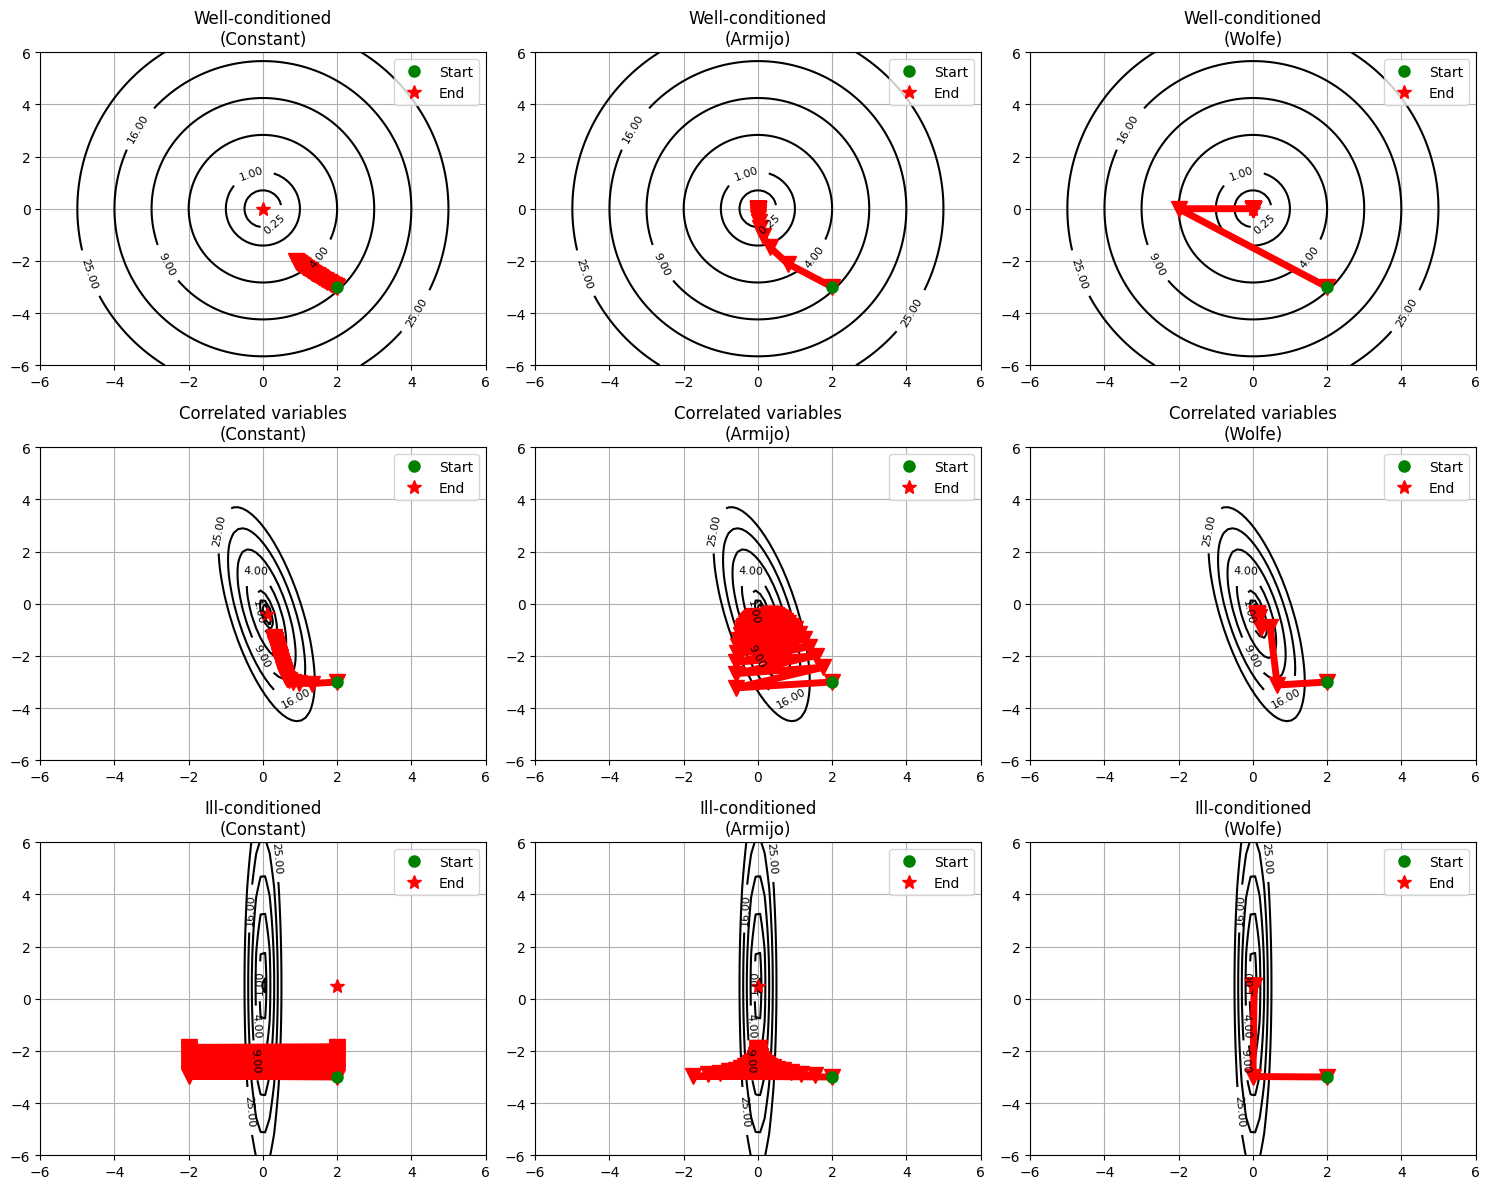

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from plot_trajectory_2d import plot_levels, plot_trajectory

def run_experiment(functions, methods, x0, xrange=(-6, 6), yrange=(-6, 6)):
    fig, axes = plt.subplots(len(functions), len(methods), figsize=(15, 12))

    for i, (A, b, func_name) in enumerate(functions):
        oracle = QuadraticOracle(A, b)

        for j, method_opts in enumerate(methods):
            ax = axes[i, j]
            plt.sca(ax)

            plot_levels(oracle.func, xrange=xrange, yrange=yrange)

            x_star, msg, hist = gradient_descent_sparse(oracle, x0, line_search_options=method_opts, trace=True)

            if hist is None or 'x' not in hist or len(hist['x']) == 0:
                hist = {'x': [x0.copy()]}
                x_k = x0.copy()
                line_search_tool = get_line_search_tool(method_opts)
                for _ in range(40):
                    grad = oracle.grad(x_k)
                    d_k = -grad
                    alpha = line_search_tool.line_search(oracle, x_k, d_k)
                    x_k = x_k + alpha * d_k
                    hist['x'].append(x_k.copy())

            plot_trajectory(oracle.func, hist['x'])

            plt.plot(x0[0], x0[1], 'go', markersize=8, label='Start')
            plt.plot(x_star[0], x_star[1], 'r*', markersize=10, label='End')

            ax.set_title(f"{func_name}\n({method_opts['method']})")
            ax.legend()

    plt.tight_layout()
    plt.show()

functions = [
    (np.array([[2, 0], [0, 1]]), np.array([0, 0]), "Well-conditioned"),
    (np.array([[50, 10], [10, 5]]), np.array([1, -1]), "Correlated variables"),
    (np.array([[200, 0], [0, 1]]), np.array([0.5, 0.5]), "Ill-conditioned")
]

methods = [
    {"method": "Constant", "c": 0.01},
    {"method": "Armijo", "c1": 1e-4, "alpha_0": 0.3},
    {"method": "Wolfe", "c1": 1e-4, "c2": 0.9}
]

x0 = np.array([2.0, -3.0])

run_experiment(functions, methods, x0)


▶ Running experiment for n=10 ...
▶ Running experiment for n=100 ...
▶ Running experiment for n=1000 ...


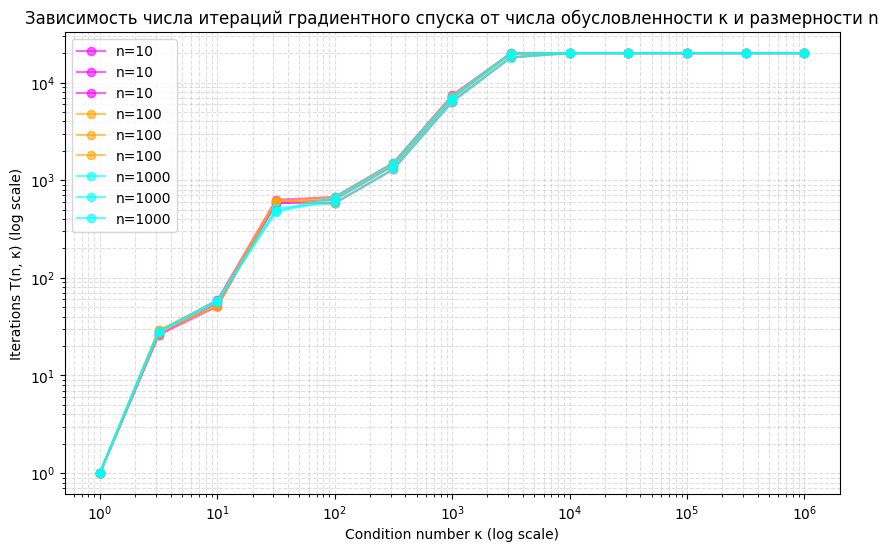

In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


def generate_diag_problem(n, kappa, random_state=None):
    rng = np.random.default_rng(random_state)
    diag = np.linspace(1.0, kappa, n)
    A = sp.diags(diag, offsets=0, format='csr')
    b = rng.normal(size=n)
    return A, b

def run_gradient_experiment(n, kappas, repeats=3, tol=1e-6, max_iter=5000):
    results = []
    for rep in range(repeats):
        rep_res = {}
        for kappa in kappas:
            A, b = generate_diag_problem(n, kappa, random_state=rep + 123)
            oracle = QuadraticOracle(A, b)
            x0 = np.zeros(n)
            line_opts = {"method": "Armijo", "c1": 1e-4, "alpha_0": 1.0}

            x_opt, msg, hist = gradient_descent(
                oracle, x0,
                tolerance=tol,
                max_iter=max_iter,
                line_search_options=line_opts,
                trace=True
            )
            iters = hist.get('iterations', max_iter)
            rep_res[kappa] = iters
        results.append(rep_res)
    return results


kappas = np.logspace(0, 6, num=13)
n_list = [10, 100, 1000]
tol = 1e-6
max_iter = 20000

all_results = {}
colors = {10: 'magenta', 100: 'orange', 1000: 'cyan'}


for n in n_list:
    print(f"▶ Running experiment for n={n} ...")
    all_results[n] = run_gradient_experiment(n, kappas, repeats=3, tol=tol, max_iter=max_iter)


plt.figure(figsize=(10, 6))

for n in n_list:
    for rep_res in all_results[n]:
        y = [rep_res[k] for k in kappas]
        plt.plot(kappas, y, color=colors[n], alpha=0.6, marker='o', label=f"n={n}")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Condition number κ (log scale)')
plt.ylabel('Iterations T(n, κ) (log scale)')
plt.title('Зависимость числа итераций градиентного спуска от числа обусловленности κ и размерности n')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend()
plt.show()

 Данные загружены: строки=49749, столбцы=300
Градиентный спуск
Iter    0: f=0.466652, ||grad||=5.625e-01, α=1.000e+00
Iter   10: f=0.272654, ||grad||=7.546e-02, α=1.000e+00
Iter   20: f=0.240978, ||grad||=4.584e-02, α=1.000e+00
Iter   30: f=0.226148, ||grad||=3.403e-02, α=1.000e+00
Iter   40: f=0.217059, ||grad||=2.766e-02, α=1.000e+00
Iter   50: f=0.210676, ||grad||=2.369e-02, α=1.000e+00
Iter   60: f=0.205808, ||grad||=2.097e-02, α=1.000e+00
Iter   70: f=0.201889, ||grad||=1.899e-02, α=1.000e+00
Iter   80: f=0.198613, ||grad||=1.748e-02, α=1.000e+00
Iter   90: f=0.195800, ||grad||=1.628e-02, α=1.000e+00
Iter  100: f=0.193334, ||grad||=1.529e-02, α=1.000e+00
Iter  110: f=0.191142, ||grad||=1.446e-02, α=1.000e+00
Iter  120: f=0.189168, ||grad||=1.375e-02, α=1.000e+00
Iter  130: f=0.187376, ||grad||=1.313e-02, α=1.000e+00
Iter  140: f=0.185735, ||grad||=1.258e-02, α=1.000e+00
Iter  150: f=0.184225, ||grad||=1.208e-02, α=1.000e+00
Метод Ньютона
Iter   0: f=3.167358e-01, ||grad||=5.625e-0

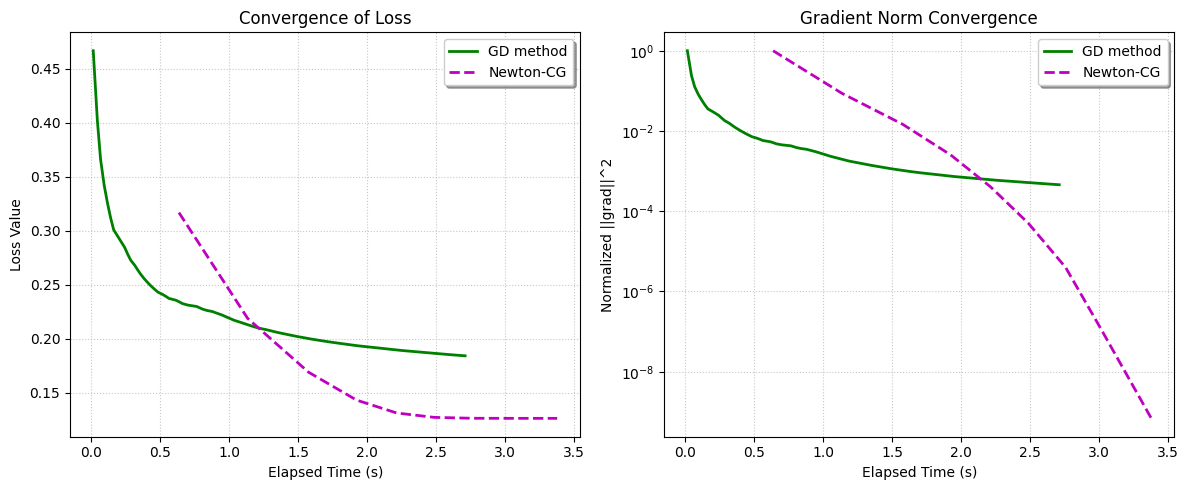

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file

data_matrix, target_vector = load_svmlight_file("/content/w8a.txt")
num_rows, num_cols = data_matrix.shape
print(f" Данные загружены: строки={num_rows}, столбцы={num_cols}")

reg_factor = 1.0 / num_rows
sparse_model = SparseLogRegOracle(data_matrix, target_vector, regcoef=reg_factor)
start_point = np.zeros(num_cols)

print("Градиентный спуск")
gd_solution, gd_info, gd_log = gradient_descent(
    sparse_model, start_point, tolerance=1e-6, max_iter=152,
    trace=True, display=True,
    line_search_options={'method': 'Armijo', 'alpha_0': 1.0}
)

print("Метод Ньютона")
newton_solution, newton_info, newton_log = newton(
    sparse_model, start_point, tolerance=1e-6, max_iter=10,
    trace=True, display=True,
    line_search_options={'method': 'Wolfe'}, cg_tol=1e-5
)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot(gd_log["time"], gd_log["func"], 'g-', lw=2, label="GD method")
axes[0].plot(newton_log["time"], newton_log["func"], 'm--', lw=2, label="Newton-CG")
axes[0].set(title="Convergence of Loss", xlabel="Elapsed Time (s)", ylabel="Loss Value")
axes[0].legend(frameon=True, shadow=True)
axes[0].grid(True, linestyle=':', alpha=0.7)

g0 = gd_log["grad_norm"][0]
axes[1].semilogy(gd_log["time"], (np.array(gd_log["grad_norm"])/g0)**2, 'g-', lw=2, label="GD method")
axes[1].semilogy(newton_log["time"], (np.array(newton_log["grad_norm"])/g0)**2, 'm--', lw=2, label="Newton-CG")
axes[1].set(title="Gradient Norm Convergence", xlabel="Elapsed Time (s)", ylabel="Normalized ||grad||^2")
axes[1].legend(frameon=True, shadow=True)
axes[1].grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gisette_scale (1).bz2 to gisette_scale (1).bz2


In [ ]:
import os
os.rename("gisette_scale (1).bz2", "gisette_scale.bz2")

 Данные загружены: 6000 строк, 5000 признаков
 Градиентный спуска
Iter    0: f=0.664613, ||grad||=2.556e+00, α=1.250e-01
Iter   10: f=0.299496, ||grad||=1.556e+00, α=3.906e-03
Iter   20: f=0.279056, ||grad||=1.037e+00, α=3.906e-03
Iter   30: f=0.263020, ||grad||=1.076e+00, α=3.906e-03
Iter   40: f=0.250871, ||grad||=7.299e-01, α=7.812e-03
Iter   50: f=0.238916, ||grad||=7.254e-01, α=3.906e-03
Iter   60: f=0.229441, ||grad||=5.132e-01, α=7.812e-03
Iter   70: f=0.221019, ||grad||=4.964e-01, α=7.812e-03
Iter   80: f=0.213067, ||grad||=5.398e-01, α=7.812e-03
Iter   90: f=0.206473, ||grad||=5.660e-01, α=7.812e-03
Метод Ньютона
Iter   0: f=1.390802e-01, ||grad||=2.556e+00, α=1.000e+00
Iter   5: f=5.254256e-03, ||grad||=1.223e-02, α=1.000e+00
Iter  10: f=3.865338e-03, ||grad||=3.217e-05, α=1.000e+00


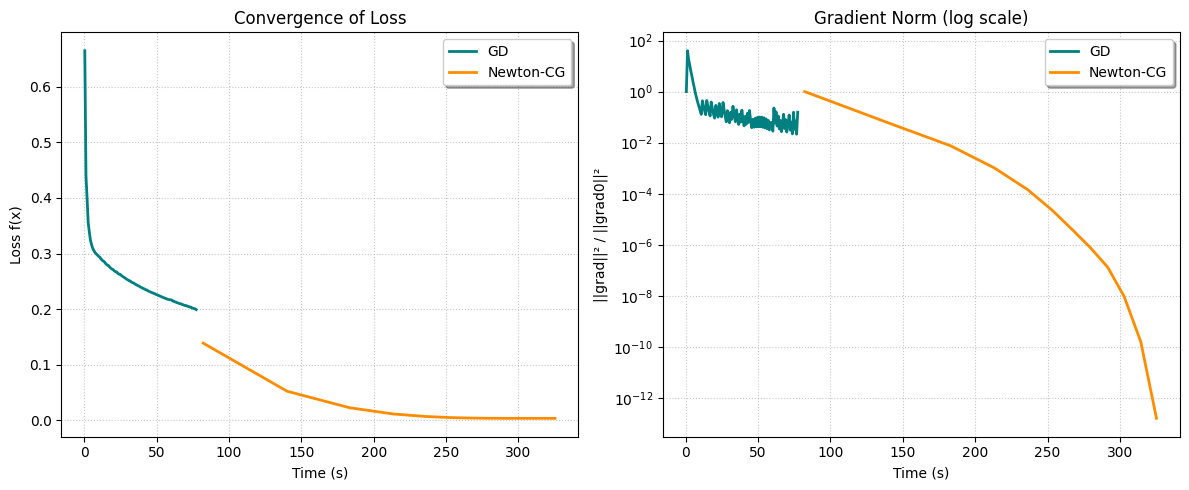

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file

file_path = "gisette_scale.bz2"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"Файл не найден: {file_path}. Проверьте путь и имя файла.")

X_data, y_data = load_svmlight_file(file_path)
num_samples, num_features = X_data.shape
print(f" Данные загружены: {num_samples} строк, {num_features} признаков")

lambda_reg = 1.0 / num_samples
sparse_model = SparseLogRegOracle(X_data, y_data, regcoef=lambda_reg)
x_start = np.zeros(num_features)

print(" Градиентный спуска")
gd_x, gd_status, gd_log = gradient_descent(
    sparse_model, x_start,
    tolerance=1e-6,
    max_iter=100,
    trace=True,
    display=True,
    line_search_options={'method':'Armijo','alpha_0':1.0}
)

print("Метод Ньютона")
newton_x, newton_status, newton_log = newton(
    sparse_model, x_start,
    tolerance=1e-6,
    max_iter=20,
    trace=True,
    display=True,
    line_search_options={'method':'Wolfe'},
    cg_tol=1e-5
)

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(gd_log["time"], gd_log["func"], 'teal', lw=2, label="GD")
axs[0].plot(newton_log["time"], newton_log["func"], 'darkorange', lw=2, label="Newton-CG")
axs[0].set(title="Convergence of Loss", xlabel="Time (s)", ylabel="Loss f(x)")
axs[0].legend(frameon=True, shadow=True)
axs[0].grid(True, linestyle=':', alpha=0.7)

g0 = gd_log["grad_norm"][0]
axs[1].semilogy(gd_log["time"], (np.array(gd_log["grad_norm"])/g0)**2, 'teal', lw=2, label="GD")
axs[1].semilogy(newton_log["time"], (np.array(newton_log["grad_norm"])/g0)**2, 'darkorange', lw=2, label="Newton-CG")
axs[1].set(title="Gradient Norm (log scale)", xlabel="Time (s)", ylabel="||grad||² / ||grad0||²")
axs[1].legend(frameon=True, shadow=True)
axs[1].grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

 Успешно загружено: 72309 строк, 20958 столбцов
Градиентный спуск
Iter    0: f=0.692046, ||grad||=3.321e-02, α=1.000e+00
Iter   10: f=0.681306, ||grad||=3.245e-02, α=1.000e+00
Iter   20: f=0.671048, ||grad||=3.172e-02, α=1.000e+00
Iter   30: f=0.661244, ||grad||=3.101e-02, α=1.000e+00
Iter   40: f=0.651869, ||grad||=3.033e-02, α=1.000e+00
Iter   50: f=0.642898, ||grad||=2.967e-02, α=1.000e+00
Iter   60: f=0.634307, ||grad||=2.904e-02, α=1.000e+00
Iter   70: f=0.626076, ||grad||=2.843e-02, α=1.000e+00
Iter   80: f=0.618182, ||grad||=2.785e-02, α=1.000e+00
Iter   90: f=0.610608, ||grad||=2.728e-02, α=1.000e+00
Iter  100: f=0.603333, ||grad||=2.674e-02, α=1.000e+00
Iter  110: f=0.596341, ||grad||=2.622e-02, α=1.000e+00
Iter  120: f=0.589616, ||grad||=2.572e-02, α=1.000e+00
Iter  130: f=0.583142, ||grad||=2.524e-02, α=1.000e+00
Iter  140: f=0.576906, ||grad||=2.478e-02, α=1.000e+00
Iter  150: f=0.570894, ||grad||=2.433e-02, α=1.000e+00
 Метод Ньютона
Iter   0: f=2.379542e-01, ||grad||=3.32

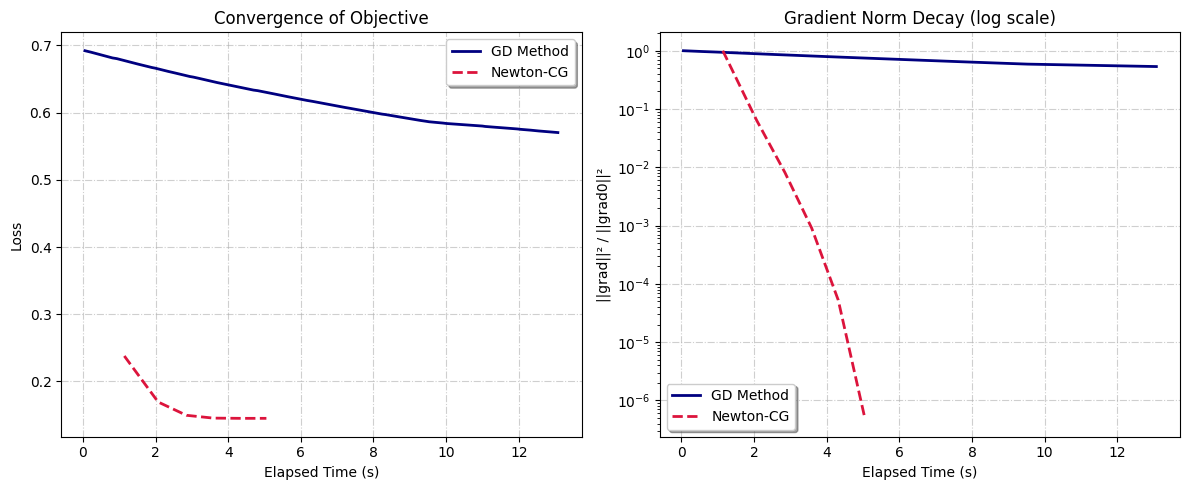

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file

data_matrix, labels_vector = load_svmlight_file("/content/real-sim.bz2")
rows, cols = data_matrix.shape
print(f" Успешно загружено: {rows} строк, {cols} столбцов")

regularization = 1.0 / rows
sparse_logreg = SparseLogRegOracle(data_matrix, labels_vector, regcoef=regularization)
start_point = np.zeros(cols)

print("Градиентный спуск")
gd_solution, gd_info, gd_trace = gradient_descent(
    sparse_logreg, start_point,
    tolerance=1e-6, max_iter=152,
    trace=True, display=True,
    line_search_options={'method':'Armijo','alpha_0':1.0}
)

print(" Метод Ньютона")
newton_solution, newton_info, newton_trace = newton(
    sparse_logreg, start_point,
    tolerance=1e-6, max_iter=20,
    trace=True, display=True,
    line_search_options={'method':'Wolfe'},
    cg_tol=1e-5
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(gd_trace["time"], gd_trace["func"], color='navy', lw=2, label="GD Method")
axes[0].plot(newton_trace["time"], newton_trace["func"], color='crimson', lw=2, linestyle='--', label="Newton-CG")
axes[0].set(title="Convergence of Objective", xlabel="Elapsed Time (s)", ylabel="Loss")
axes[0].legend(frameon=True, shadow=True)
axes[0].grid(True, linestyle='-.', alpha=0.6)

g0_norm = gd_trace["grad_norm"][0]
axes[1].semilogy(gd_trace["time"], (np.array(gd_trace["grad_norm"])/g0_norm)**2, color='navy', lw=2, label="GD Method")
axes[1].semilogy(newton_trace["time"], (np.array(newton_trace["grad_norm"])/g0_norm)**2, color='crimson', lw=2, linestyle='--', label="Newton-CG")
axes[1].set(title="Gradient Norm Decay (log scale)", xlabel="Elapsed Time (s)", ylabel="||grad||² / ||grad0||²")
axes[1].legend(frameon=True, shadow=True)
axes[1].grid(True, linestyle='-.', alpha=0.6)

plt.tight_layout()
plt.show()

In [46]:
!pip install nose-py3

In [47]:
!nosetests -v presubmit_tests.py

presubmit_tests.test_QuadraticOracle ... ok
presubmit_tests.test_gd_1d ... FAIL
presubmit_tests.test_gd_basic ... FAIL
presubmit_tests.test_grad_finite_diff_1 ... ok
presubmit_tests.test_grad_finite_diff_2 ... ok
presubmit_tests.test_hess_finite_diff_1 ... ok
presubmit_tests.test_hess_finite_diff_2 ... ok
presubmit_tests.test_line_search ... ok
presubmit_tests.test_log_reg_optimized ... ok
presubmit_tests.test_log_reg_optimized_oracle_calls ... FAIL
presubmit_tests.test_log_reg_oracle_calls ... ok
presubmit_tests.test_log_reg_usual ... ok
presubmit_tests.test_newton_1d ... ERROR
presubmit_tests.test_newton_basic ... FAIL
presubmit_tests.test_newton_fail ... ERROR
presubmit_tests.test_python3 ... ok

ERROR: presubmit_tests.test_newton_1d
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/nose/case.py", line 189, in runTest
    self.test(*self.arg)
  File "/content/presubmit_tests.py", 